In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [62]:
model_path="yolo11n-seg/yolo11n-seg.onnx"
classes_path="yolo11n-seg/yolo11n-seg.txt"
image_path="../photo/car.jpg"

In [64]:
print("Current Working Directory:", os.getcwd())
print("config Dosyası Var mı?:", os.path.exists(model_path))
print("class Dosyası Var mı?:", os.path.exists(classes_path))
print("image Dosyası Var mı?:", os.path.exists(image_path))

Current Working Directory: C:\Users\Monster\OneDrive\Masaüstü\OpencvDnn\Onnx
config Dosyası Var mı?: True
class Dosyası Var mı?: True
image Dosyası Var mı?: True


In [25]:
# Modeli yükle
net = cv2.dnn.readNetFromONNX(model_path)

In [27]:
# Görüntüyü oku
image = cv2.imread(image_path)
orig_h, orig_w = image.shape[:2]

In [29]:
# Blob hazırla
blob = cv2.dnn.blobFromImage(image, 1/255.0, (640, 640), swapRB=True, crop=False)
net.setInput(blob)

In [31]:

# Çıktıları al
outputs = net.forward(net.getUnconnectedOutLayersNames())
out, protos = outputs[0], outputs[1]


In [33]:

out = np.squeeze(out).T
protos = np.squeeze(protos)

In [35]:
boxes, confidences, class_ids, mask_embeddings = [], [], [], []

for det in out:
    scores = det[4:84]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    if confidence > 0.5:
        cx, cy, w, h = det[:4]
        x = int((cx - w / 2) * orig_w / 640)
        y = int((cy - h / 2) * orig_h / 640)
        w = int(w * orig_w / 640)
        h = int(h * orig_h / 640)

        boxes.append([x, y, w, h])
        confidences.append(float(confidence))
        class_ids.append(int(class_id))
        mask_embeddings.append(det[84:])

indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.45)

In [37]:
result_img = image.copy()

if len(indices) > 0:
    indices = np.array(indices).flatten()
    for i in indices:
        mask_emb = mask_embeddings[i]

        # Maske çıkar
        mask = protos.transpose(1, 2, 0) @ mask_emb
        mask = 1 / (1 + np.exp(-mask))  # sigmoid
        mask = cv2.resize(mask, (orig_w, orig_h))
        mask = (mask > 0.5).astype(np.uint8)

        # Maske renklendir (kutusuz)
        colored_mask = np.zeros_like(image)
        colored_mask[:, :, 2] = (mask * 255)  # kırmızı maske
        result_img = cv2.addWeighted(result_img, 1, colored_mask, 0.5, 0)

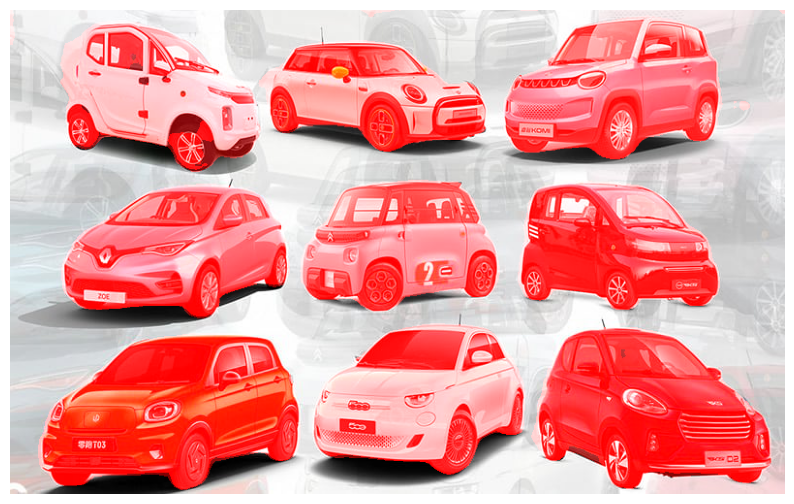

In [39]:
# Sonucu göster
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

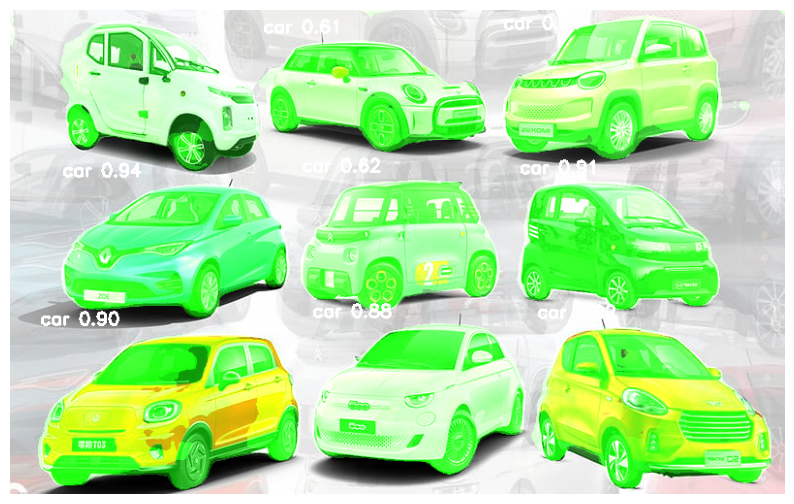

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# ----------------------------
# 1. Model ve class listesi
# ----------------------------
 # kendi model yolunu yaz
net = cv2.dnn.readNetFromONNX(model_path)

with open(classes_path, "r") as f:
    class_names = [cname.strip() for cname in f.readlines()]

# Her sınıfa random renk ata
colors = {i: [random.randint(0,255) for _ in range(3)] for i in range(len(class_names))}

# ----------------------------
# 2. Görsel yükle
# ----------------------------
image_path = "car.jpg"   # kendi görselini yaz
image = cv2.imread(image_path)
orig_h, orig_w = image.shape[:2]

# ----------------------------
# 3. Blob oluştur
# ----------------------------
blob = cv2.dnn.blobFromImage(image, 1/255.0, (640, 640), swapRB=True, crop=False)
net.setInput(blob)

# ----------------------------
# 4. Model çıktısını al
# ----------------------------
outputs = net.forward(net.getUnconnectedOutLayersNames())
out, protos = outputs[0], outputs[1]

out = np.squeeze(out).T
protos = np.squeeze(protos)

boxes, confidences, class_ids, mask_embeddings = [], [], [], []

for det in out:
    scores = det[4:4+len(class_names)]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    if confidence > 0.5:  # threshold
        cx, cy, w, h = det[:4]
        x = int((cx - w / 2) * orig_w / 640)
        y = int((cy - h / 2) * orig_h / 640)
        w = int(w * orig_w / 640)
        h = int(h * orig_h / 640)

        boxes.append([x, y, w, h])
        confidences.append(float(confidence))
        class_ids.append(int(class_id))
        mask_embeddings.append(det[4+len(class_names):])  # mask embedding

# ----------------------------
# 5. NMS
# ----------------------------
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.45)

# Çıkış görseli
result_img = image.copy()

# ----------------------------
# 6. Maske + class yazdırma
# ----------------------------
if len(indices) > 0:
    indices = np.array(indices).flatten()
    for i in indices:
        x, y, w, h = boxes[i]
        class_id = class_ids[i]
        confidence = confidences[i]
        mask_emb = mask_embeddings[i]

        # Maske çıkar
        mask = protos.transpose(1, 2, 0) @ mask_emb
        mask = 1 / (1 + np.exp(-mask))  # sigmoid
        mask = cv2.resize(mask, (orig_w, orig_h))
        mask = (mask > 0.5).astype(np.uint8)

        # Renkli maske
        color = colors[class_id]
        colored_mask = np.zeros_like(image)
        for c in range(3):
            colored_mask[:, :, c] = mask * color[c]
        result_img = cv2.addWeighted(result_img, 1, colored_mask, 0.5, 0)

        # Class ismi + güven skoru yaz
        label = f"{class_names[class_id]} {confidence:.2f}"
        cv2.putText(result_img, label, (x, max(20, y-10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

# ----------------------------
# 7. Sonucu göster
# ----------------------------
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
